# CFMM liquidity on an orde book

- $f(x, y)$ - the CFMM's invariant function
- $A$ - current pool reserve of the base asset
- $B$ - current pool reserve of the quote asset
- $\Delta p$ - tick size
- $p_{\mathrm{m}}$ - marginal price (or, mid price)
- $p_n$ - the $n$-th tick below $p_{\mathrm{m}}$
- $a_n$ - the cumulative buy quantity from $p_{\mathrm{m}}$ to $p_n$
- $\Delta a_n$ - the size of the buy order at $p_n$

## The general case

$$
\begin{aligned}
p_{\mathrm{m}} &= \frac{\frac{\partial f}{\partial x}}{\frac{\partial f}{\partial y}} \\
p_0 &= p_{\mathrm{m}} \\
p_n &= p_{n-1} - \Delta p \\
a_0 &= 0 \\
a_n &= a: f(A, B) = f(A + a, B - p_n a) \\
\Delta a_0 &= 0 \\
\Delta a_n &= a_n - a_{n-1} \\
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def compute_bids(compute_p_m, compute_a_n, A, B, dp, num_ticks, trading_fee, **kwargs):
    p_n = compute_p_m(A, B, **kwargs) * (1 - trading_fee)
    a_n = 0
    delta_a_n = 0

    arr_p_n = [p_n]
    arr_a_n = [a_n]
    arr_delta_a_n = [delta_a_n]
    
    for n in range(1, num_ticks + 1):
        p_n -= dp
        a_n = compute_a_n(A, B, p_n, **kwargs)
        delta_a_n = a_n - arr_a_n[n - 1]
        arr_p_n.append(p_n)
        arr_a_n.append(a_n)
        arr_delta_a_n.append(delta_a_n)

    return np.array(arr_p_n), np.array(arr_delta_a_n), np.array(arr_a_n)


def compute_asks(compute_p_m, compute_a_n, A, B, dp, num_ticks, trading_fee, **kwargs):
    p_n = compute_p_m(A, B, **kwargs) * (1 + trading_fee)
    a_n = 0
    delta_a_n = 0

    arr_p_n = [p_n]
    arr_a_n = [a_n]
    arr_delta_a_n = [delta_a_n]

    for n in range(1, num_ticks + 1):
        p_n += dp
        a_n = compute_a_n(A, B, p_n, **kwargs)
        delta_a_n = a_n - arr_a_n[n - 1]
        arr_p_n.append(p_n)
        arr_a_n.append(a_n)
        arr_delta_a_n.append(delta_a_n)

    return np.array(arr_p_n), np.array(arr_delta_a_n), np.array(arr_a_n)


def plot(compute_p_m, compute_bid_a_n, compute_ask_a_n, A, B, dp, num_ticks=25, trading_fee=0, filename="", **kwargs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Compute and plot bids
    prices, order_sizes, depths = compute_bids(compute_p_m, compute_bid_a_n, A, B, dp, num_ticks, trading_fee, **kwargs)
    ax1.bar(prices, order_sizes, color="green", width=dp * 0.8)
    ax2.step(prices, depths, color="green", where="post")

    print("Bids:")
    for i in range(len(prices)):
        print(f"({prices[i]}, {order_sizes[i]})")

    # Compute and plot asks
    prices, order_sizes, depths = compute_asks(compute_p_m, compute_ask_a_n, A, B, dp, num_ticks, trading_fee, **kwargs)
    ax1.bar(prices, order_sizes, color="red", width=dp * 0.8)
    ax2.step(prices, depths, color="red", where="post")

    ax2.set_xlabel("price ($)")
    ax1.set_ylabel("order size (SOL)")
    ax2.set_ylabel("order depth (SOL)")
    ax2.set_ylim(0)

    # Print the bids and asks for rust tests
    
    print("\nAsks:")
    for i in range(len(prices)):
        print(f"({prices[i]}, {order_sizes[i]})")
    

    plt.tight_layout()
    if filename != "":
        plt.savefig(filename)
    plt.show()

## Xyk

$$
f(x, y) = xy
$$

$$
p_{\mathrm{m}} = \frac{B}{A}
$$

| BUY                        | SELL                      |
| -------------------------- | ------------------------- |
| $a_n = -A + \frac{B}{p_n}$ | $a_n = A - \frac{B}{p_n}$ |

Bids:
(198.0, 0.0)
(197.0, 0.015228426395939021)
(196.0, 0.005179736869367124)
(195.0, 0.005232862375719405)
(194.0, 0.005286809410520732)
(193.0, 0.0053415950002670964)
(192.0, 0.005397236614853362)
(191.0, 0.005453752181500793)
(190.0, 0.005511160099200829)
(189.0, 0.00556947925368978)
(188.0, 0.005628729032984392)
(187.0, 0.0056889293434976285)
(186.0, 0.005750100626760846)
(185.0, 0.005812263876780133)
(184.0, 0.005875440658049236)
(183.0, 0.005939653124257704)
(182.0, 0.0060049240377109125)
(181.0, 0.006071276789508806)
(180.0, 0.006138735420503361)
(179.0, 0.0062073246430787155)
(178.0, 0.006277069863787732)
(177.0, 0.006347997206881173)
(176.0, 0.006420133538777684)
(175.0, 0.006493506493506329)
(174.0, 0.006568144499178974)
(173.0, 0.006644076805528032)

Asks:
(202.0, 0.0)
(203.0, 0.014778325123152691)
(204.0, 0.004829518014102252)
(205.0, 0.004782400765184103)
(206.0, 0.004735969689793951)
(207.0, 0.004690211528539989)
(208.0, 0.00464511334076545)
(209.0, 0.004600662495399366)

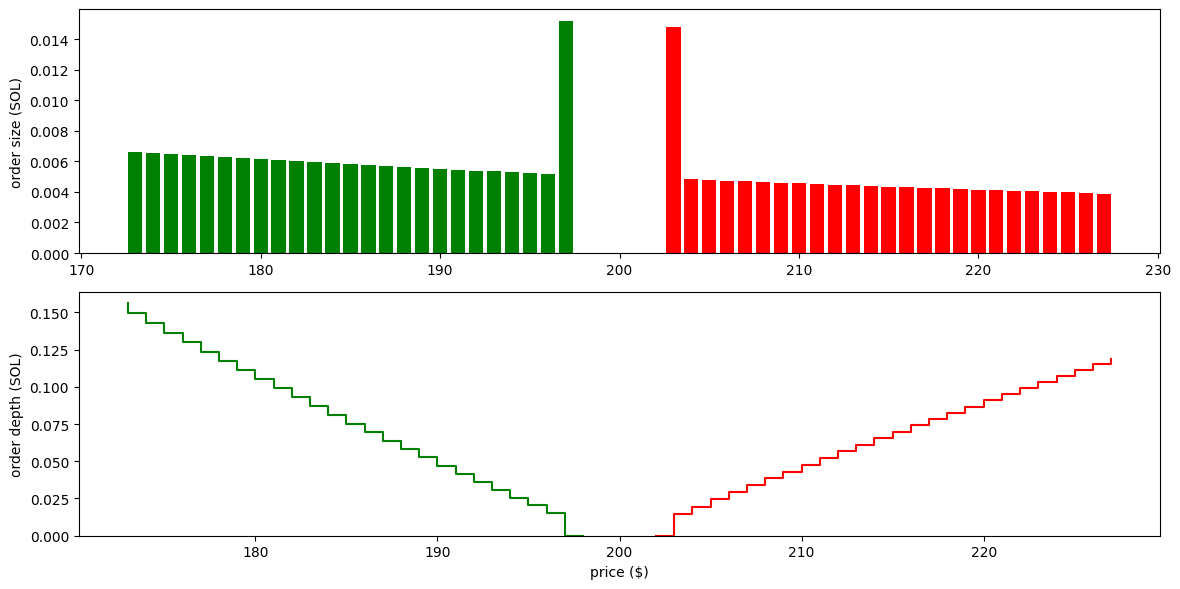

In [9]:
def compute_xyk_f(A, B):
    return A * B


def compute_xyk_p_m(A, B):
    return B / A


def compute_xyk_bid_a_n(A, B, p_n):
    return B / p_n - A


def compute_xyk_ask_a_n(A, B, p_n):
    return A - B / p_n


plot(compute_xyk_p_m,
     compute_xyk_bid_a_n,
     compute_xyk_ask_a_n,
     A=1,
     B=200,
     dp=1,
     num_ticks=25,
     trading_fee=0.01,
     filename="1-xyk.png")

## Solidly

$$
f(x, y) = x^3 \left(\frac{y}{R}\right) + x \left(\frac{y}{R}\right)^3
$$

$$
p_{\mathrm{m}} = \frac{3 R^2 A^2 B + B^3}{R^2 A^3 + 3 A B^2}
$$

| BUY                                                                                        | SELL                                                                                      |
| ------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------- |
| $\alpha = A + a$                                                                           | $\alpha = A - a$                                                                          |
| $\beta = \frac{B - p a}{R}$                                                                | $\beta = \frac{B + p a}{R}$                                                               |
| $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                         | $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                        |
| $g'(a) = -\frac{p}{R} \alpha^3 + a \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3$ | $g'(a) = \frac{p}{R} \alpha^3 - a \alpha^2 \beta + \frac{3p}{R} \alpha \beta^2 - \beta^3$ |

Bids:
(0.99, 0.0)
(0.98, 0.34721100178611075)
(0.97, 0.05344637504143063)
(0.96, 0.04396510867612552)
(0.95, 0.03837687816907137)
(0.94, 0.034686244395805976)
(0.9299999999999999, 0.03208021617932988)
(0.9199999999999999, 0.030159704813467636)
(0.9099999999999999, 0.028704023855810168)
(0.8999999999999999, 0.027580524207403423)
(0.8899999999999999, 0.02670438944720288)
(0.8799999999999999, 0.02601874371865487)
(0.8699999999999999, 0.025483984768867707)
(0.8599999999999999, 0.02507168987351227)
(0.8499999999999999, 0.024760951233634976)
(0.8399999999999999, 0.024536076993140865)
(0.8299999999999998, 0.024385096773103743)
(0.8199999999999998, 0.02429876030509781)
(0.8099999999999998, 0.02426984883512573)
(0.7999999999999998, 0.024292690820683083)
(0.7899999999999998, 0.024362814627711393)
(0.7799999999999998, 0.024476695237197643)
(0.7699999999999998, 0.024631566837010954)
(0.7599999999999998, 0.02482528244639637)
(0.7499999999999998, 0.025056207744963088)
(0.7399999999999998, 0.02532314

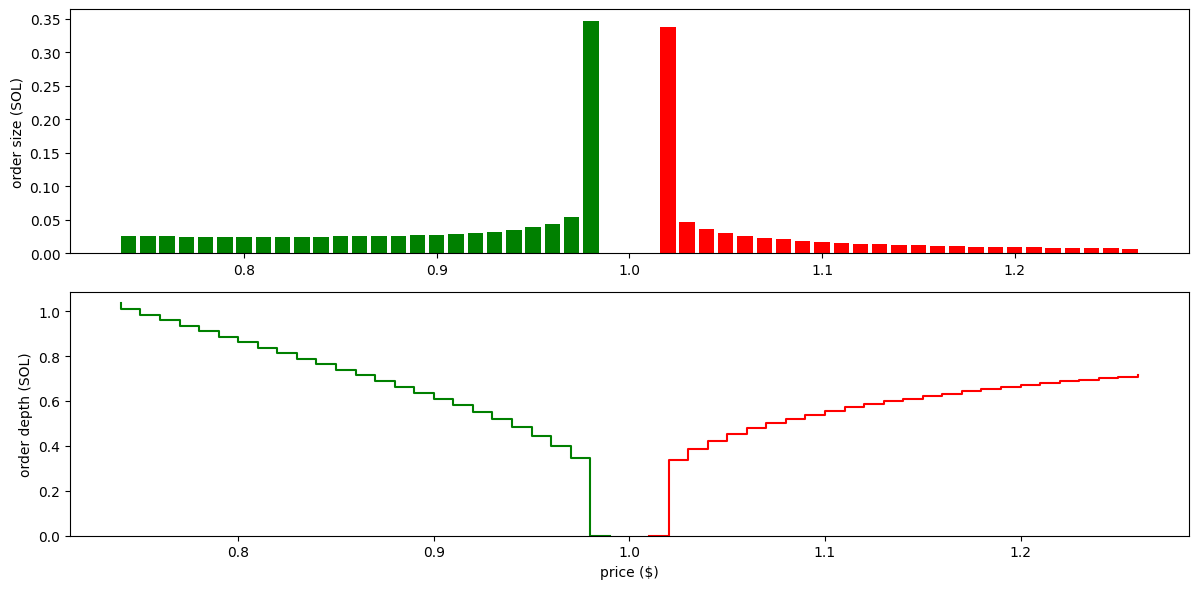

In [16]:
def compute_solidly_f(A, B, R):
    return A * A * A * B / R + A * B * B * B / R / R / R


def compute_solidly_p_m(A, B, R):
    return (3 * R * R * A * A * B + B * B * B) / (R * R * A * A * A + 3 * A * B * B)


def compute_solidly_bid_a_n(A, B, p_n, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A + a_prev
        beta = (B - p_n * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = - p_n * alpha * alpha * alpha / R + 3 * alpha * alpha * beta - 3 * p_n * alpha * beta * beta / R + beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")
    

def compute_solidly_ask_a_n(A, B, p_n, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A - a_prev
        beta = (B + p_n * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = p_n * alpha * alpha * alpha / R - 3 * alpha * alpha * beta + 3 * p_n * alpha * beta * beta / R - beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")


plot(compute_solidly_p_m,
     compute_solidly_bid_a_n,
     compute_solidly_ask_a_n,
     A=1,
     B=1,
     R=1,
     dp=0.01,
     num_ticks=25,
     trading_fee=0.01,
     filename="2-solidly.png")

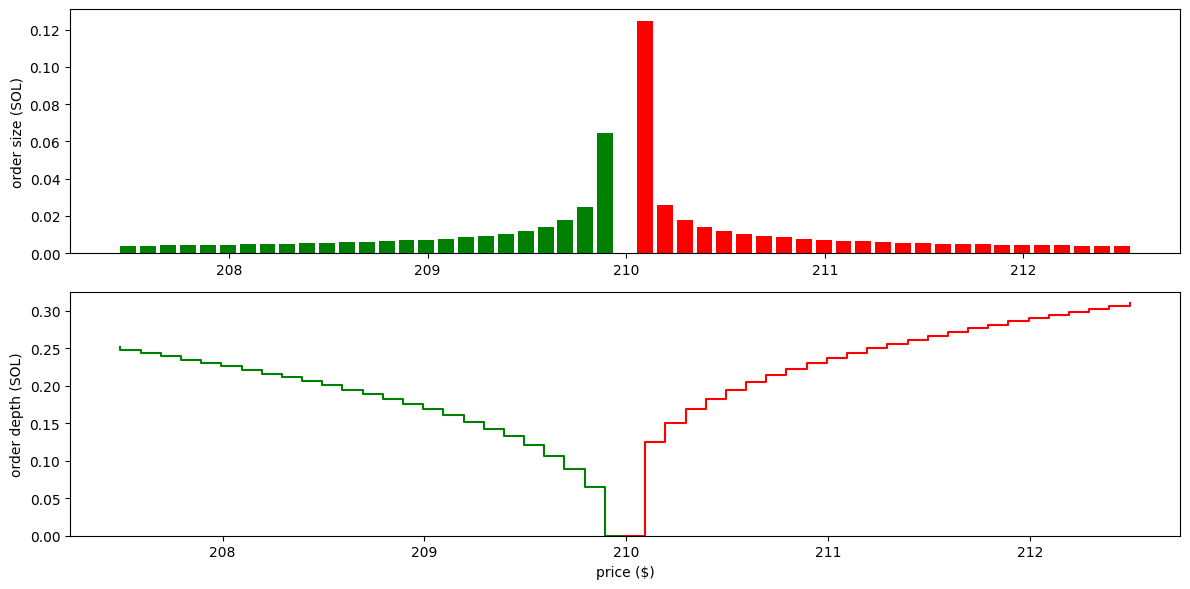

In [4]:
plot(compute_solidly_p_m,
     compute_solidly_bid_a_n,
     compute_solidly_ask_a_n,
     A=1,
     B=200,
     R=210,
     dp=0.1,
     num_ticks=25,
     filename="3-solidly-price-jump.png")